In [6]:
#pip install nltk wordcloud spacy

In [7]:

# 1. Importar las bibliotecas necesarias
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Descargar y cargar el modelo de spaCy para español

In [ ]:

!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")


# 3. Cargar datos

In [9]:

# Puedes descargar un conjunto de datos de reseñas de películas en español desde:
# https://www.kaggle.com/datasets/blessondensil294/imdb-movie-reviews-dataset-in-spanish
# Para este ejemplo, supongamos que hemos cargado los datos en un DataFrame de pandas.

# Para fines de demostración, crearemos un pequeño corpus manualmente
corpus = [
    "La película fue fascinante y llena de emoción. Los actores hicieron un trabajo excelente.",
    "No me gustó la película. El guión era predecible y los personajes no tenían profundidad.",
    "Una obra maestra del cine moderno. La dirección y la cinematografía fueron excepcionales.",
    "La película es aburrida y demasiado larga. No la recomendaría.",
    "Disfruté cada momento de la película. La banda sonora fue increíble."
]

# Convertir el corpus en un DataFrame
df = pd.DataFrame({'resena': corpus})

### 4. Preprocesamiento del texto

In [10]:
# Función para limpiar y normalizar el texto
def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres especiales y números
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)
    # Eliminar espacios adicionales
    texto = re.sub(r"\s+", " ", texto)
    return texto.strip()

# Aplicar la función al DataFrame
df['resena_limpia'] = df['resena'].apply(preprocesar_texto)


### 5. Tokenización y Lematización ###

In [11]:
# Función para tokenizar y lematizar
def tokenizar_lemmatizar(texto):
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens

# Aplicar la función al DataFrame
df['tokens'] = df['resena_limpia'].apply(tokenizar_lemmatizar)

print("Tokens y lemas de las reseñas:")
print(df[['resena_limpia', 'tokens']])

Tokens y lemas de las reseñas:
                                       resena_limpia  \
0  la película fue fascinante y llena de emoción ...   
1  no me gustó la película el guión era predecibl...   
2  una obra maestra del cine moderno la dirección...   
3  la película es aburrida y demasiado larga no l...   
4  disfruté cada momento de la película la banda ...   

                                              tokens  
0  [película, fascinante, lleno, emoción, actor, ...  
1  [gustar, película, guión, predecible, personaj...  
2  [obra, maestro, cine, moderno, dirección, cine...  
3            [película, aburrido, largo, recomendar]  
4  [disfruté, momento, película, banda, sonoro, i...  


### 6. Análisis de Frecuencias ###


Frecuencias de las palabras:
película          4
fascinante        1
sonoro            1
banda             1
momento           1
disfruté          1
recomendar        1
largo             1
aburrido          1
excepcional       1
cinematografía    1
dirección         1
moderno           1
cine              1
maestro           1
obra              1
profundidad       1
tener             1
personaje         1
predecible        1
guión             1
gustar            1
excelente         1
trabajo           1
actor             1
emoción           1
lleno             1
increíble         1
Name: count, dtype: int64


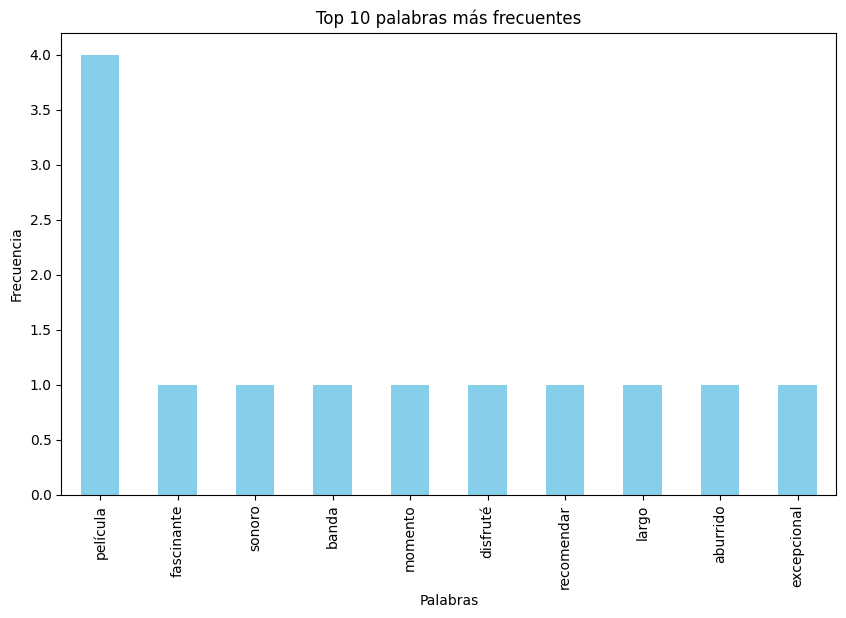

In [12]:
# Unir todos los tokens en una sola lista
todos_los_tokens = [token for tokens in df['tokens'] for token in tokens]

# Calcular frecuencias
frecuencias = pd.Series(todos_los_tokens).value_counts()

print("\nFrecuencias de las palabras:")
print(frecuencias)

# Visualizar las palabras más comunes
plt.figure(figsize=(10,6))
frecuencias.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 palabras más frecuentes")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

### 7. Nube de Palabras ###

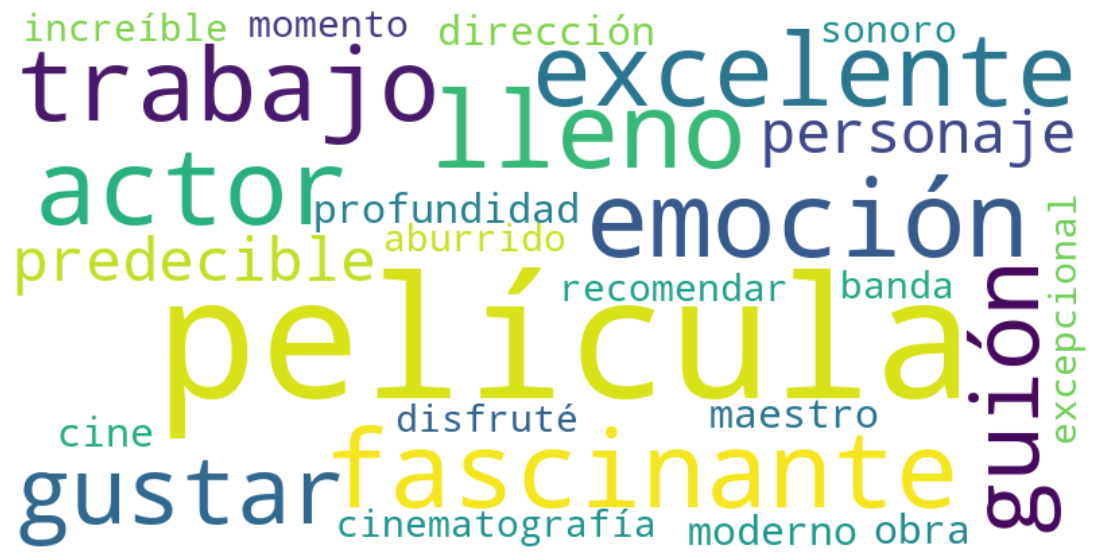

In [13]:
# Generar la nube de palabras
texto_para_nube = " ".join(todos_los_tokens)
wordcloud = WordCloud(stopwords=list(STOP_WORDS), background_color="white", colormap="viridis", width=800, height=400).generate(texto_para_nube)

# Mostrar la nube de palabras
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### 8. Bag-of-Words ###

In [14]:
# Unir los tokens nuevamente en texto para vectorización
df['texto_procesado'] = df['tokens'].apply(lambda tokens: " ".join(tokens))

# Vectorización usando CountVectorizer
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['texto_procesado'])

# Mostrar la matriz Bag-of-Words
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

In [15]:
df_bow

,aburrido,actor,banda,cine,cinematografía,dirección,disfruté,emoción,excelente,excepcional,...,momento,obra,película,personaje,predecible,profundidad,recomendar,sonoro,tener,trabajo
0,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,1,0
2,0,0,0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0


### 9. TF-IDF ###

* El TF-IDF (Frecuencia de Termino - Frecuencia Inversa de Documento) es una medida numérica que permite expresar como de relevante es una palabra para un documento en una colección de documentos (o corpus).


* Construir la Bolsa de Palabras con TF-IDF en vez de con frecuencias evita dar "importancia" a texto muy largos y con mucha repetición de palabras, frente a textos cortos y con pocas repeticiones de palabras.


* La media de ***TF-IDF*** tiene dos componentes que son:
    
    * ***TF*** (Term Frecuency): Es la frecuencia con la que aparece la palabra en un documento del corpus. Esta se define como:
    
    $$tf(t,d) = 1 + log(f_{t,d})$$
    
    * ***IDF*** (Inverse Document Frequency): La frecuencia inversa del documento nos indica lo común que es una palabra en el corpus.
    
    $$idf(t,D) = log(1 + \frac{N}{n_t})$$
    

* ***TF-IDF*** queda definido como:
$$tfidf(t,d,D) = tf(t,d) \cdot idf(t,D)$$



### Ejemplos:

* Veamos un ejemplo dado el siguiente corpus de 2 documentos con las siguientes palabras:

```
corpus = ["messi messi messi ronaldo ronaldo balon",
          "messi ronaldo futbol futbol futbol"]
```

* ***Ejemplo 1***: Calculamos el ***tf-idf*** de la palabra "**messi**" para el documento 1:
    
    * ***TF***:
        - t: número de veces que aparece la palabra "messi" en el documento 1 -> 3
        - d: número de palabras que tiene el documento 1 -> 6
        $$tf(t,d) = 1 + log(\frac{3}{6}) =  0,69$$
        
    * ***IDF***:
        - n<sub>t</sub>: número de documentos en los que aparece la palabra 'messi' -> 2
        - D: número total de documentos en el corpus -> 2
        $$idf(t,D) = log(1 + \frac{2}{2}) = 0,3$$
        
    * ***TF-IDF***:
    $$tfidf(t,d,D) = tf(t,d) \cdot idf(t,D) = 0,69 * 0,3 = 0,21$$

In [16]:
# Vectorización usando TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['texto_procesado'])

# Mostrar la matriz TF-IDF
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [17]:
df_tfidf

,aburrido,actor,banda,cine,cinematografía,dirección,disfruté,emoción,excelente,excepcional,...,momento,obra,película,personaje,predecible,profundidad,recomendar,sonoro,tener,trabajo
0,0.000000,0.39786,0.000000,0.000000,0.000000,0.000000,0.000000,0.39786,0.39786,0.000000,...,0.000000,0.000000,0.224148,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.39786
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.224148,0.39786,0.39786,0.39786,0.000000,0.000000,0.39786,0.00000
2,0.000000,0.00000,0.000000,0.377964,0.377964,0.377964,0.000000,0.00000,0.00000,0.377964,...,0.000000,0.377964,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000
3,0.549036,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.309317,0.00000,0.00000,0.00000,0.549036,0.000000,0.00000,0.00000
4,0.000000,0.00000,0.433661,0.000000,0.000000,0.000000,0.433661,0.00000,0.00000,0.000000,...,0.433661,0.000000,0.244317,0.00000,0.00000,0.00000,0.000000,0.433661,0.00000,0.00000


### 10. Análisis de Sentimientos ###

In [18]:
# Para el análisis de sentimientos, podemos usar una lista de palabras positivas y negativas o utilizar una biblioteca externa
# Aquí usaremos una lista sencilla para demostrar

palabras_positivas = ['fascinante', 'excelente', 'maestra', 'excepcional', 'disfrutar', 'increíble']
palabras_negativas = ['aburrido', 'predecible', 'largo', 'no recomendar', 'no gustar']

def analizar_sentimiento(tokens):
    puntuacion = 0
    for token in tokens:
        if token in palabras_positivas:
            puntuacion += 1
        elif token in palabras_negativas:
            puntuacion -= 1
    if puntuacion > 0:
        return 'Positivo'
    elif puntuacion < 0:
        return 'Negativo'
    else:
        return 'Neutral'

df['sentimiento'] = df['tokens'].apply(analizar_sentimiento)

print("\nAnálisis de sentimientos:")
print(df[['resena', 'sentimiento']])




Análisis de sentimientos:
                                              resena sentimiento
0  La película fue fascinante y llena de emoción....    Positivo
1  No me gustó la película. El guión era predecib...    Negativo
2  Una obra maestra del cine moderno. La direcció...    Positivo
3  La película es aburrida y demasiado larga. No ...    Negativo
4  Disfruté cada momento de la película. La banda...    Positivo


### 11. Modelado de Tópicos con LDA ###

In [19]:
# Usar LDA para identificar temas en las reseñas
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(X_bow)

# Mostrar los tópicos
palabras = vectorizer.get_feature_names_out()
for i, tema in enumerate(lda.components_):
    print(f"\nTópico {i + 1}:")
    palabras_importantes = [palabras[i] for i in tema.argsort()[-10:]]
    print(" + ".join(palabras_importantes))



Tópico 1:
lleno + fascinante + excelente + predecible + gustar + guión + personaje + profundidad + tener + película

Tópico 2:
disfruté + banda + increíble + dirección + cine + cinematografía + maestro + moderno + obra + excepcional


### 12. Clustering con K-Means ###

In [20]:
# Usar K-Means para agrupar las reseñas
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Añadir las etiquetas al DataFrame
df['cluster'] = kmeans.labels_

print("\nAsignación de clusters:")
print(df[['resena', 'cluster']])

# Evaluar el modelo con el coeficiente de silueta
score = silhouette_score(X_tfidf, kmeans.labels_)
print(f"\nCoeficiente de silueta: {score}")


Asignación de clusters:
                                              resena  cluster
0  La película fue fascinante y llena de emoción....        1
1  No me gustó la película. El guión era predecib...        0
2  Una obra maestra del cine moderno. La direcció...        0
3  La película es aburrida y demasiado larga. No ...        1
4  Disfruté cada momento de la película. La banda...        1

Coeficiente de silueta: 0.005738575137288544


### 13. Visualización de Dependencias Gramaticales ###

In [21]:
# Analizar una reseña con spaCy
doc = nlp(df['resena'][0])

print("\nDependencias gramaticales de la primera reseña:")
for token in doc:
    print(f"Palabra: {token.text}, Etiqueta: {token.pos_}, Dependencia: {token.dep_}, Gobernante: {token.head.text}")


Dependencias gramaticales de la primera reseña:
Palabra: La, Etiqueta: DET, Dependencia: det, Gobernante: película
Palabra: película, Etiqueta: NOUN, Dependencia: nsubj, Gobernante: fascinante
Palabra: fue, Etiqueta: AUX, Dependencia: cop, Gobernante: fascinante
Palabra: fascinante, Etiqueta: ADJ, Dependencia: ROOT, Gobernante: fascinante
Palabra: y, Etiqueta: CCONJ, Dependencia: cc, Gobernante: llena
Palabra: llena, Etiqueta: ADJ, Dependencia: conj, Gobernante: fascinante
Palabra: de, Etiqueta: ADP, Dependencia: case, Gobernante: emoción
Palabra: emoción, Etiqueta: NOUN, Dependencia: nmod, Gobernante: llena
Palabra: ., Etiqueta: PUNCT, Dependencia: punct, Gobernante: fascinante
Palabra: Los, Etiqueta: DET, Dependencia: det, Gobernante: actores
Palabra: actores, Etiqueta: NOUN, Dependencia: nsubj, Gobernante: hicieron
Palabra: hicieron, Etiqueta: VERB, Dependencia: ROOT, Gobernante: hicieron
Palabra: un, Etiqueta: DET, Dependencia: det, Gobernante: trabajo
Palabra: trabajo, Etiqueta: 

In [22]:
# Visualización gráfica (requiere instalar 'spacy[lookups]' y 'spacy-streamlit' para interfaces interactivas)
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

### 14. Reconocimiento de Entidades Nombradas ###

In [30]:
resena

'Disfruté cada momento de la película. La banda sonora fue increíble.'

In [31]:
print("\nEntidades nombradas en las reseñas:")
for idx, resena in enumerate(df['resena']):
    doc = nlp(resena)
    print(f"\nReseña {idx + 1}:")
    for ent in doc.ents:
        print(f" - Texto: {ent.text}, Etiqueta: {ent.label_}")


Entidades nombradas en las reseñas:

Reseña 1:
 - Texto: Los actores hicieron un trabajo excelente, Etiqueta: MISC

Reseña 2:
 - Texto: El guión, Etiqueta: MISC

Reseña 3:
 - Texto: La dirección, Etiqueta: MISC

Reseña 4:
 - Texto: No la recomendaría, Etiqueta: MISC

Reseña 5:
 - Texto: La banda sonora, Etiqueta: MISC


### 15. Dividir en Oraciones ###

In [34]:
# Tokenización en oraciones usando spaCy
df['oraciones'] = df['resena'].apply(lambda resena: [sent.text for sent in nlp(resena).sents])

print("\nOraciones tokenizadas:")
for idx, oraciones in enumerate(df['oraciones']):
    print(f"\nReseña {idx + 1}:")
    for i, oracion in enumerate(oraciones):
        print(f"  Oración {i + 1}: {oracion}")



Oraciones tokenizadas:

Reseña 1:
  Oración 1: La película fue fascinante y llena de emoción.
  Oración 2: Los actores hicieron un trabajo excelente.

Reseña 2:
  Oración 1: No me gustó la película.
  Oración 2: El guión era predecible y los personajes no tenían profundidad.

Reseña 3:
  Oración 1: Una obra maestra del cine moderno.
  Oración 2: La dirección y la cinematografía fueron excepcionales.

Reseña 4:
  Oración 1: La película es aburrida y demasiado larga.
  Oración 2: No la recomendaría.

Reseña 5:
  Oración 1: Disfruté cada momento de la película.
  Oración 2: La banda sonora fue increíble.


### 16. Expansión de Contracciones y Corrección Ortográfica

In [24]:
pip install autocorrect


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\USUARIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from autocorrect import Speller
from nltk.tokenize import word_tokenize
import re

# Inicializar corrector ortográfico
spell = Speller(lang='es')

# Diccionario para expandir contracciones (puedes ampliarlo según el contexto)
CONTRACCIONES = {
    "al": "a el",
    "del": "de el",
    "pa'": "para",
    "túve": "tuve",
    "estába": "estaba"
}

# Función para expandir contracciones
def expandir_contracciones(texto):
    palabras = word_tokenize(texto)
    palabras_expandidas = [CONTRACCIONES.get(palabra, palabra) for palabra in palabras]
    return " ".join(palabras_expandidas)

# Función para corregir errores ortográficos
def corregir_ortografia(texto):
    palabras = word_tokenize(texto)
    palabras_corregidas = [spell(palabra) for palabra in palabras]
    return " ".join(palabras_corregidas)

# Texto de ejemplo
texto = "No me gustó la película pa' nada, estába muy aburrida y larga."

# Aplicar expansión de contracciones
texto_expandidas = expandir_contracciones(texto)
print("Texto con contracciones expandidas:")
print(texto_expandidas)

# Aplicar corrección ortográfica
texto_corregido = corregir_ortografia(texto_expandidas)
print("\nTexto con corrección ortográfica:")
print(texto_corregido)


### 17. Similitud entre Documentos ###

In [ ]:

# Calcular la similitud entre las reseñas
print("\nSimilitud entre reseñas:")
for i in range(len(df)):
    for j in range(i+1, len(df)):
        doc1 = nlp(df['resena_limpia'][i])
        doc2 = nlp(df['resena_limpia'][j])
        similitud = doc1.similarity(doc2)
        print(f"Reseña {i+1} y Reseña {j+1}: {similitud:.2f}")


### 18. Embeddings de Palabras con spaCy ###

In [ ]:
# Obtener vectores de palabras
doc = nlp(df['resena_limpia'][0])
print("\nVectores de palabras de la primera reseña:")
for token in doc:
    if not token.is_stop and not token.is_punct:
        print(f"Palabra: {token.text}, Vector: {token.vector[:5]}, {token.vector.shape}...")  # Mostrar solo los primeros 5 elementos


Vectores de palabras de la primera reseña:
Palabra: película, Vector: [-3.6264365  -0.9559927  -2.2527745   0.22264278 -1.7663169 ], (96,)...
Palabra: fascinante, Vector: [-0.38264203  3.1780987   0.5824764   1.7391647   0.40407038], (96,)...
Palabra: llena, Vector: [-1.7387525   0.16082445  0.16939886 -0.16163886  2.0583048 ], (96,)...
Palabra: emoción, Vector: [-0.68330824 -0.72113216  1.6522106   1.5237617  -0.8473085 ], (96,)...
Palabra: actores, Vector: [-2.1395452  1.6502981 -2.179372   0.7386341  1.0992743], (96,)...
Palabra: trabajo, Vector: [ 0.11326253  0.7139778   0.77029604 -0.40160176  0.7337957 ], (96,)...
Palabra: excelente, Vector: [ 0.68135107 -0.14274257 -0.7073028   0.9322484   5.893058  ], (96,)...
